# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

There's also a cell that allows us to step through hyperparamters for any particular model to examine how the model overfits as a hyparameter changes.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you should select your final/best model and hyperparameters to run one time only and then make the business performance tables for that final model. Note once we've decided on the final model and hyperparameters we're allowed to make several trial runs of our final model train looking for a good performance on the testing data, as long as we don't make any changes to the model hyperparameters from our final choice.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [3]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline



In [2]:
# This will let you see all the particular library vertsions you have loaded
# %pip list

In [4]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(97496, 22)
CPU times: user 83.2 ms, sys: 14.4 ms, total: 97.6 ms
Wall time: 98.6 ms


Cardnum_unique_count_for_card_state_1  Card_Merchdesc_State_total_3  \
0                                      1                          3.62   
1                                      1                         31.42   
2                                      1                        178.49   
3                                      1                          3.62   
4                                      1                          7.24   

   card_state_max_14  Cardnum_vdratio_0by30  card_state_total_amount_1_by_60  \
0               3.62               0.000023                         0.016667   
1              31.42               0.000023                         0.016667   
2             178.49               0.000023                         0.016667   
3               3.62               0.000023                         0.016667   
4               3.62               0.033333                         0.016667   

   Cardnum_total_1  Card_Merchdesc_Zip_total_7  Cardnum_max_1  \
0             3.62                        3.62           3.62   
1            31.42                       31.42          31.42   
2           178.49                      178.49         178.49   
3             3.62                        3.62           3.62   
4             7.24                        7.24           3.62   

   state_des_total_1  card_zip_total_amount_1_by_60  ...  \
0               3.62                       0.016667  ...   
1              31.42                       0.016667  ...   
2             178.49                       0.016667  ...   
3               3.62                       0.016667  ...   
4               7.24                       0.016667  ...   

   Card_dow_unique_count_for_merch_zip_1  \
0                                      1   
1                                      1   
2                                      1   
3                                      1   
4                                      1   

   Card_dow_unique_count_for_merch_zip_60  Card_dow_count_7  \
0                                       1                 1   
1                                       1                 1   
2                                       1                 1   
3                                       1                 1   
4                                       1                 2   

   Cardnum_unique_count_for_card_state_3  Card_dow_total_7  Cardnum_avg_1  \
0                                      1              3.62           3.62   
1                                      1             31.42          31.42   
2                                      1            178.49         178.49   
3                                      1              3.62           3.62   
4                                      1              7.24           3.62   

   Cardnum_count_14  Cardnum_vdratio_1by30  Recnum  Fraud  
0                 1               0.000023       1      0  
1                 1               0.000023       2      0  
2                 1               0.000023       3      0  
3                 1               0.000023       4      0  
4                 2               0.033333       5      0  

[5 rows x 22 columns]

In [5]:
# set the number of variables desired here, and set the names of the y and record label properly
NVARS = 10

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
detect_rate = .03
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'Cardnum_unique_count_for_card_state_1',
 'Card_Merchdesc_State_total_3',
 'card_state_max_14',
 'Cardnum_vdratio_0by30',
 'card_state_total_amount_1_by_60',
 'Cardnum_total_1',
 'Card_Merchdesc_Zip_total_7',
 'Cardnum_max_1',
 'state_des_total_1',
 'card_zip_total_amount_1_by_60']

In [6]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

Recnum  Fraud  Cardnum_unique_count_for_card_state_1  \
0       1      0                                      1   
1       2      0                                      1   
2       3      0                                      1   
3       4      0                                      1   
4       5      0                                      1   

   Card_Merchdesc_State_total_3  card_state_max_14  Cardnum_vdratio_0by30  \
0                          3.62               3.62               0.000023   
1                         31.42              31.42               0.000023   
2                        178.49             178.49               0.000023   
3                          3.62               3.62               0.000023   
4                          7.24               3.62               0.033333   

   card_state_total_amount_1_by_60  Cardnum_total_1  \
0                         0.016667             3.62   
1                         0.016667            31.42   
2                         0.016667           178.49   
3                         0.016667             3.62   
4                         0.016667             7.24   

   Card_Merchdesc_Zip_total_7  Cardnum_max_1  state_des_total_1  \
0                        3.62           3.62               3.62   
1                       31.42          31.42              31.42   
2                      178.49         178.49             178.49   
3                        3.62           3.62               3.62   
4                        7.24           3.62               7.24   

   card_zip_total_amount_1_by_60  
0                       0.016667  
1                       0.016667  
2                       0.016667  
3                       0.016667  
4                       0.016667

In [7]:
vars.shape

(97496, 12)

In [8]:
vars['Fraud'].sum()

2047

In [9]:
print("fraud rate in data is",vars['Fraud'].sum()/len(vars))

fraud rate in data is 0.020995733158283417


In [10]:
vars.head(10)

Recnum  Fraud  Cardnum_unique_count_for_card_state_1  \
0       1      0                                      1   
1       2      0                                      1   
2       3      0                                      1   
3       4      0                                      1   
4       5      0                                      1   
5       6      0                                      1   
6       7      0                                      1   
7       8      0                                      1   
8       9      0                                      1   
9      10      0                                      1   

   Card_Merchdesc_State_total_3  card_state_max_14  Cardnum_vdratio_0by30  \
0                          3.62               3.62               0.000023   
1                         31.42              31.42               0.000023   
2                        178.49             178.49               0.000023   
3                          3.62               3.62               0.000023   
4                          7.24               3.62               0.033333   
5                          3.67               3.67               0.000023   
6                          3.62               3.62               0.000023   
7                        230.32             230.32               0.000023   
8                         62.11              62.11               0.000023   
9                         10.86               3.62               0.033333   

   card_state_total_amount_1_by_60  Cardnum_total_1  \
0                         0.016667             3.62   
1                         0.016667            31.42   
2                         0.016667           178.49   
3                         0.016667             3.62   
4                         0.016667             7.24   
5                         0.016667             3.67   
6                         0.016667             3.62   
7                         0.016667           230.32   
8                         0.016667            62.11   
9                         0.016667            10.86   

   Card_Merchdesc_Zip_total_7  Cardnum_max_1  state_des_total_1  \
0                        3.62           3.62               3.62   
1                       31.42          31.42              31.42   
2                      178.49         178.49             178.49   
3                        3.62           3.62               3.62   
4                        7.24           3.62               7.24   
5                        3.67           3.67               3.67   
6                        3.62           3.62               7.24   
7                      230.32         230.32             230.32   
8                       62.11          62.11              62.11   
9                       10.86           3.62              10.86   

   card_zip_total_amount_1_by_60  
0                       0.016667  
1                       0.016667  
2                       0.016667  
3                       0.016667  
4                       0.016667  
5                       0.016667  
6                       0.016667  
7                       0.016667  
8                       0.016667  
9                       0.016667

In [12]:
vars.shape

(97496, 12)

In [11]:
vars.describe()

Recnum         Fraud  Cardnum_unique_count_for_card_state_1  \
count  97496.000000  97496.000000                           97496.000000   
mean   48915.137247      0.020996                               1.724266   
std    28262.212670      0.143371                               1.568565   
min        1.000000      0.000000                               1.000000   
25%    24428.750000      0.000000                               1.000000   
50%    48916.000000      0.000000                               1.000000   
75%    73402.250000      0.000000                               2.000000   
max    97852.000000      1.000000                              21.000000   

       Card_Merchdesc_State_total_3  card_state_max_14  Cardnum_vdratio_0by30  \
count                  97496.000000       97496.000000           97496.000000   
mean                     620.451951         603.535848               0.003696   
std                     4031.661363        1194.174516               0.005834   
min                        0.010000           0.010000               0.000018   
25%                       48.497500          67.187500               0.000595   
50%                      170.885000         258.885000               0.001282   
75%                      534.192500         729.900000               0.004167   
max                   306633.410000       47900.000000               0.033333   

       card_state_total_amount_1_by_60  Cardnum_total_1  \
count                     9.749600e+04     97496.000000   
mean                      7.998480e-03      1153.075663   
std                       6.643459e-03      5676.370925   
min                       1.901394e-07         0.010000   
25%                       1.543743e-03        91.652500   
50%                       5.918865e-03       348.585000   
75%                       1.666667e-02      1084.000000   
max                       1.666667e-02    307468.060000   

       Card_Merchdesc_Zip_total_7  Cardnum_max_1  state_des_total_1  \
count                97496.000000   97496.000000       97496.000000   
mean                   675.610484     615.716869        1080.068475   
std                   4074.152260    1214.006863        4397.448150   
min                      0.010000       0.010000           0.010000   
25%                     52.460000      70.445000          84.650000   
50%                    188.960000     272.000000         295.000000   
75%                    590.000000     757.600000        1015.560000   
max                 306633.410000   47900.000000      306633.410000   

       card_zip_total_amount_1_by_60  
count                   9.749600e+04  
mean                    1.087674e-02  
std                     6.574362e-03  
min                     5.626259e-07  
25%                     3.826080e-03  
50%                     1.666667e-02  
75%                     1.666667e-02  
max                     1.666667e-02

In [13]:
# find the row i vars that corresponds to 11/1 for the OOT
test = vars[vars['Recnum'] > 85264]
test.head(10)

Recnum  Fraud  Cardnum_unique_count_for_card_state_1  \
84935   85265      0                                      1   
84936   85266      0                                      1   
84937   85267      0                                      1   
84938   85268      0                                      1   
84939   85269      0                                      1   
84940   85270      0                                      1   
84941   85271      0                                      1   
84942   85272      0                                      1   
84943   85273      0                                      1   
84944   85274      0                                      1   

       Card_Merchdesc_State_total_3  card_state_max_14  Cardnum_vdratio_0by30  \
84935                        174.61             225.00               0.001282   
84936                         53.00             206.90               0.000694   
84937                         25.00             531.25               0.000595   
84938                         97.17              97.17               0.000433   
84939                          6.51               6.51               0.000641   
84940                        170.00             170.00               0.000794   
84941                        250.00             250.00               0.000641   
84942                         15.00              15.00               0.004167   
84943                        300.00            2105.00               0.001333   
84944                        133.20              97.02               0.000641   

       card_state_total_amount_1_by_60  Cardnum_total_1  \
84935                         0.007283           174.61   
84936                         0.000311            53.00   
84937                         0.000346            25.00   
84938                         0.000987            97.17   
84939                         0.003082             6.51   
84940                         0.016667           170.00   
84941                         0.001063           250.00   
84942                         0.000356            15.00   
84943                         0.000252           300.00   
84944                         0.001507            97.02   

       Card_Merchdesc_Zip_total_7  Cardnum_max_1  state_des_total_1  \
84935                      174.61         174.61             174.61   
84936                       53.00          53.00              53.00   
84937                       25.00          25.00              25.00   
84938                       97.17          97.17              97.17   
84939                        6.51           6.51               6.51   
84940                      170.00         170.00             170.00   
84941                      250.00         250.00             250.00   
84942                       15.00          15.00              15.00   
84943                      300.00         300.00             300.00   
84944                      133.20          97.02              97.02   

       card_zip_total_amount_1_by_60  
84935                       0.007283  
84936                       0.000414  
84937                       0.000837  
84938                       0.016667  
84939                       0.003082  
84940                       0.016667  
84941                       0.016667  
84942                       0.016667  
84943                       0.001770  
84944                       0.001507

In [14]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

Fraud
0      0
1      0
2      0
3      0
4      0

## Scale and truncate field values

In [15]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

Cardnum_unique_count_for_card_state_1  Card_Merchdesc_State_total_3  \
count                           97496.000000                  97496.000000   
mean                                1.724266                    620.451951   
std                                 1.568565                   4031.661363   
min                                 1.000000                      0.010000   
25%                                 1.000000                     48.497500   
50%                                 1.000000                    170.885000   
75%                                 2.000000                    534.192500   
max                                21.000000                 306633.410000   

       card_state_max_14  Cardnum_vdratio_0by30  \
count       97496.000000           97496.000000   
mean          603.535848               0.003696   
std          1194.174516               0.005834   
min             0.010000               0.000018   
25%            67.187500               0.000595   
50%           258.885000               0.001282   
75%           729.900000               0.004167   
max         47900.000000               0.033333   

       card_state_total_amount_1_by_60  Cardnum_total_1  \
count                     9.749600e+04     97496.000000   
mean                      7.998480e-03      1153.075663   
std                       6.643459e-03      5676.370925   
min                       1.901394e-07         0.010000   
25%                       1.543743e-03        91.652500   
50%                       5.918865e-03       348.585000   
75%                       1.666667e-02      1084.000000   
max                       1.666667e-02    307468.060000   

       Card_Merchdesc_Zip_total_7  Cardnum_max_1  state_des_total_1  \
count                97496.000000   97496.000000       97496.000000   
mean                   675.610484     615.716869        1080.068475   
std                   4074.152260    1214.006863        4397.448150   
min                      0.010000       0.010000           0.010000   
25%                     52.460000      70.445000          84.650000   
50%                    188.960000     272.000000         295.000000   
75%                    590.000000     757.600000        1015.560000   
max                 306633.410000   47900.000000      306633.410000   

       card_zip_total_amount_1_by_60  
count                   9.749600e+04  
mean                    1.087674e-02  
std                     6.574362e-03  
min                     5.626259e-07  
25%                     3.826080e-03  
50%                     1.666667e-02  
75%                     1.666667e-02  
max                     1.666667e-02

In [16]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [17]:
# Outlier treatment: use this to limit variables. For some problems it helps
Clip = 10

In [18]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

Cardnum_unique_count_for_card_state_1  Card_Merchdesc_State_total_3  \
count                           9.749600e+04                  9.749600e+04   
mean                           -3.469048e-17                  4.081233e-18   
std                             1.000000e+00                  1.000000e+00   
min                            -4.651796e-01                 -3.201629e-01   
25%                            -4.651796e-01                 -2.929033e-01   
50%                            -4.651796e-01                 -2.240972e-01   
75%                             1.782986e-01                 -1.984612e-02   
max                             1.009425e+01                  2.269460e+01   

       card_state_max_14  Cardnum_vdratio_0by30  \
count       9.749600e+04           9.749600e+04   
mean       -6.704883e-18           3.935475e-17   
std         1.000000e+00           1.000000e+00   
min        -6.218751e-01          -6.303853e-01   
25%        -5.510254e-01          -5.315000e-01   
50%        -3.488489e-01          -4.137753e-01   
75%         1.479138e-01           8.066848e-02   
max         1.260917e+01           5.080044e+00   

       card_state_total_amount_1_by_60  Cardnum_total_1  \
count                     9.749600e+04     9.749600e+04   
mean                      7.579433e-18     5.830333e-18   
std                       1.000000e+00     1.000000e+00   
min                      -1.203935e+00    -3.380457e-01   
25%                      -9.715928e-01    -3.087690e-01   
50%                      -3.130319e-01    -2.266879e-01   
75%                       1.304770e+00     8.252156e-03   
max                       1.304770e+00     1.816439e+01   

       Card_Merchdesc_Zip_total_7  Cardnum_max_1  state_des_total_1  \
count                9.749600e+04   9.749600e+04       9.749600e+04   
mean                -8.745500e-19   2.332133e-18       7.579433e-18   
std                  1.000000e+00   1.000000e+00       1.000000e+00   
min                 -3.344411e-01  -6.134136e-01      -4.088849e-01   
25%                 -3.063479e-01  -5.416745e-01      -3.752926e-01   
50%                 -2.332358e-01  -3.363880e-01      -2.918079e-01   
75%                 -1.843099e-02   1.582023e-01      -5.828940e-03   
max                  2.184938e+01   1.237852e+01       1.747256e+01   

       card_zip_total_amount_1_by_60  
count                   9.749600e+04  
mean                    2.332133e-17  
std                     1.000000e+00  
min                    -1.654333e+00  
25%                    -1.072449e+00  
50%                     8.806819e-01  
75%                     8.806819e-01  
max                     8.806819e-01

In [19]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this OOT record number to whatever is appropriate for your data
oot_recnum = 85264
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()

Fraud    297
dtype: int64

## Look at PCA

In [20]:
len(X_trntst.columns)

10

In [21]:
X_trntst_save = X_trntst.copy()

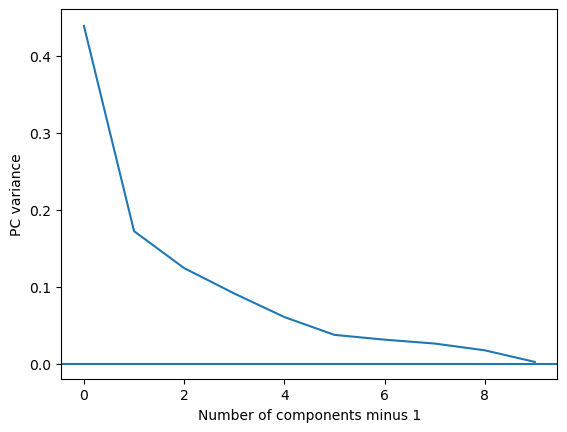

In [20]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [22]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

PC1       PC2       PC3       PC4
0 -0.931997 -1.294843 -1.045941 -0.551778
1 -0.889385 -1.287901 -1.045749 -0.562298
2 -0.663951 -1.251178 -1.044735 -0.617955
3 -0.931997 -1.294843 -1.045941 -0.551778
4 -0.569339 -3.077095  0.529671  3.890458

In [23]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

PC1       PC2       PC3       PC4
85264 -0.334342 -0.085474  0.368506 -0.542885
85265 -0.611558 -1.564658  1.132749  3.963817
85266  2.533229 -0.732062 -1.207460 -1.063625
85267  0.335966 -0.549806  0.425849 -1.109490
85268  0.072640 -1.171385 -1.045130 -0.628508

In [24]:
X_trntst.describe()

Cardnum_unique_count_for_card_state_1  Card_Merchdesc_State_total_3  \
count                           85264.000000                  85264.000000   
mean                                0.004006                      0.002584   
std                                 1.007299                      1.028998   
min                                -0.465180                     -0.320163   
25%                                -0.465180                     -0.293674   
50%                                -0.465180                     -0.225157   
75%                                 0.178299                     -0.020644   
max                                10.094246                     22.694604   

       card_state_max_14  Cardnum_vdratio_0by30  \
count       85264.000000           85264.000000   
mean            0.002218              -0.005848   
std             1.007176               0.994799   
min            -0.621875              -0.630287   
25%            -0.553332              -0.533290   
50%            -0.350594              -0.413775   
75%             0.152238               0.080668   
max            12.609173               5.080044   

       card_state_total_amount_1_by_60  Cardnum_total_1  \
count                     85264.000000     85264.000000   
mean                         -0.007766         0.004520   
std                           1.000525         1.034771   
min                          -1.203935        -0.338046   
25%                          -0.977463        -0.309297   
50%                          -0.328074        -0.226555   
75%                           1.304770         0.010481   
max                           1.304770        18.164389   

       Card_Merchdesc_Zip_total_7  Cardnum_max_1  state_des_total_1  \
count                85264.000000   85264.000000       85264.000000   
mean                     0.002794       0.004216           0.008068   
std                      1.029094       1.009820           1.034248   
min                     -0.334441      -0.613414          -0.408885   
25%                     -0.307200      -0.543095          -0.375548   
50%                     -0.234719      -0.334152          -0.293076   
75%                     -0.019024       0.163865          -0.004482   
max                     21.849376      12.378520          17.472558   

       card_zip_total_amount_1_by_60  
count                   85264.000000  
mean                       -0.013637  
std                         1.005500  
min                        -1.654333  
25%                        -1.098739  
50%                         0.809417  
75%                         0.880682  
max                         0.880682

In [25]:
X_oot_orig_pca.describe()

PC1           PC2           PC3           PC4
count  12232.000000  12232.000000  12232.000000  12232.000000
mean      -0.062183     -0.129072     -0.044563      0.005728
std        1.676944      1.281999      1.007320      0.967544
min       -1.383588     -4.209479     -5.832933     -8.489678
25%       -0.859069     -1.263636     -0.638956     -0.518440
50%       -0.497223     -0.119613     -0.165828     -0.200087
75%        0.194880      0.991257      0.277359      0.267414
max       42.152148      6.030181      9.266694      6.530529

In [26]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [27]:
X_trntst_pca.describe()

PC1           PC2           PC3           PC4
count  8.526400e+04  8.526400e+04  8.526400e+04  8.526400e+04
mean  -2.166695e-18  1.000013e-17 -4.000053e-18 -4.000053e-18
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
min   -6.526256e-01 -3.636734e+00 -8.037193e+00 -9.806233e+00
25%   -4.228937e-01 -9.188634e-01 -5.258932e-01 -5.379161e-01
50%   -2.348431e-01  3.142195e-02 -7.406513e-02 -1.548343e-01
75%    1.186565e-01  9.157873e-01  2.945836e-01  2.958944e-01
max    2.029108e+01  5.147482e+00  1.251383e+01  1.254159e+01

In [28]:
X_oot_orig_pca.describe()

PC1           PC2           PC3           PC4
count  12232.000000  12232.000000  12232.000000  12232.000000
mean      -0.029234     -0.096903     -0.039408      0.005912
std        0.788370      0.962486      0.890796      0.998674
min       -0.650457     -3.160348     -5.158193     -8.762826
25%       -0.403868     -0.948699     -0.565043     -0.535120
50%       -0.233756     -0.089802     -0.146646     -0.206525
75%        0.091617      0.744205      0.245275      0.276018
max       19.816696      4.527275      8.194745      6.740643

In [29]:
X_trntst_pca.shape

(85264, 4)

In [30]:
X_oot_orig_pca.shape

(12232, 4)

## Subsample the larger class if desired

In [31]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.020524488647025708
(3464, 10) 3464


In [32]:
# We do a manual cross validation by running each model nitermax times for each choice of hyperparameters. The good
# statistical measurement of the model performance is the average across all these nitermax runs.
niter = 0
nitermax = 10
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and/or just explore one model type. You can also just rerun any single cell multiple times (hit shift-enter on that cell) as you "manually" explore different model hyperparameters.

In [33]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [58]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 300, 500]
}

grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=3,                                         # 5-fold cross-validation
    scoring='roc_auc',                            # Scoring based on AUC or any other metric
    n_jobs=-1,                                    # Use all cores
    verbose=1
)

# Perform grid search to optimize hyperparameters
grid_search.fit(X_trntst, Y_trntst.values.ravel())

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Fit the best model using the optimized hyperparameters on the train/test split
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 135 candidates, totalling 405 fits


/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pin/miniconda

Best Parameters: {'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}


In [43]:
%%time
# Logistic regression

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(penalty = "l2", C = 0.001, solver='saga', max_iter=500)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.6932270916334662 0.6646464646464646 0.48484848484848486
1 0.6875 0.68 0.48148148148148145
2 0.6887254901960784 0.6768060836501901 0.48148148148148145
3 0.684887459807074 0.6936758893280632 0.48148148148148145
4 0.6870915032679739 0.6787072243346007 0.49158249158249157
5 0.6834008097165992 0.6912621359223301 0.48148148148148145
6 0.6836569579288025 0.6828793774319066 0.48148148148148145
7 0.6780650542118432 0.6987295825771325 0.48148148148148145
8 0.6869350862777321 0.6772983114446529 0.48148148148148145
9 0.6964285714285714 0.6583011583011583 0.4781144781144781
trn    0.686992
tst    0.680231
oot    0.482492
dtype: float64
CPU times: user 5.81 s, sys: 7.07 s, total: 12.9 s
Wall time: 1.37 s


In [78]:
# Define the parameter grid for tuning
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [5, 10,20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,                                         # 5-fold cross-validation
    scoring='accuracy',                            # Scoring based on AUC or any other metric
    n_jobs=-1,                                    # Use all cores
)

# Perform grid search to optimize hyperparameters
grid_search.fit(X_trntst, Y_trntst.values.ravel())

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Fit the best model using the optimized hyperparameters on the train/test split
best_model = grid_search.best_estimator_


/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
480 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validat

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 5}


In [44]:
%%time
# Single DT

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(max_depth = 5, min_samples_split = 5, min_samples_leaf = 5, criterion = "gini", max_features = None) #class_weight = {0:1, 1:5})
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean())
model_counter = model_counter + 1

0 0.7034313725490197 0.6273764258555133 0.5622895622895623
1 0.7121831561733443 0.715370018975332 0.531986531986532
2 0.6846026490066225 0.7453874538745388 0.5925925925925926
3 0.7105691056910569 0.698076923076923 0.5925925925925926
4 0.6982343499197432 0.6686507936507936 0.5656565656565656
5 0.6994359387590653 0.6699410609037328 0.5656565656565656
6 0.7105921601334445 0.6823956442831216 0.5555555555555556
7 0.7155664221678891 0.6921606118546845 0.5791245791245792
8 0.7118367346938775 0.6952380952380952 0.5656565656565656
9 0.7045267489711934 0.7457943925233644 0.5959595959595959
trn    0.705098
tst    0.694039
oot    0.570707
dtype: float64
CPU times: user 1.72 s, sys: 38.3 ms, total: 1.76 s
Wall time: 1.79 s


In [102]:
# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 500],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    "max_depth": [10, 30, 50],
    'criterion': ['gini', 'entropy']  
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,                                         # 5-fold cross-validation
    scoring='accuracy',                            # Scoring based on AUC or any other metric
    n_jobs=-1,                                    # Use all cores
)

# Perform grid search to optimize hyperparameters
grid_search.fit(X_trntst, Y_trntst.values.ravel())

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Fit the best model using the optimized hyperparameters on the train/test split
best_model = grid_search.best_estimator_

Best Parameters: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}


In [45]:
%%time
# RF
# n_estimators -> the number of trees in the forest
# max_features -> number of features to consider when looking for the best split m=p開根號

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(criterion="gini", min_samples_leaf=150, min_samples_split=150, n_estimators= 300, max_depth=None)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.7277187244480785 0.7400379506641366 0.5252525252525253
1 0.7388059701492538 0.7242647058823529 0.5286195286195287
2 0.7442434210526315 0.7284644194756554 0.5420875420875421
3 0.7192402972749794 0.7309833024118738 0.5218855218855218
4 0.7315112540192926 0.7470355731225297 0.5185185185185185
5 0.7393790849673203 0.6977186311787072 0.5185185185185185
6 0.7312091503267973 0.7395437262357415 0.5185185185185185
7 0.730327868852459 0.7415094339622641 0.5218855218855218
8 0.7288273615635179 0.7452107279693486 0.5353535353535354
9 0.7267536704730831 0.7309160305343512 0.5353535353535354
trn    0.731802
tst    0.732568
oot    0.526599
dtype: float64
CPU times: user 4min 30s, sys: 1.25 s, total: 4min 31s
Wall time: 4min 32s


In [127]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 5, 10, 15],
}

grid_search = GridSearchCV(
    lgb.LGBMClassifier(random_state=42),
    param_grid,
    cv=5,                                         # 5-fold cross-validation
    scoring='accuracy',                            # Scoring based on AUC or any other metric
    n_jobs=-1,                                    # Use all cores
)

# Perform grid search to optimize hyperparameters
grid_search.fit(X_trntst, Y_trntst.values.ravel())

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Fit the best model using the optimized hyperparameters on the train/test split
best_model = grid_search.best_estimator_

[LightGBM] [Info] Number of positive: 1400, number of negative: 66811[LightGBM] [Info] Number of positive: 1400, number of negative: 66812

[LightGBM] [Info] Number of positive: 1400, number of negative: 66811
[LightGBM] [Info] Number of positive: 1400, number of negative: 66811
[LightGBM] [Info] Number of positive: 1400, number of negative: 66811
[LightGBM] [Info] Number of positive: 1400, number of negative: 66811
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Total Bi

In [142]:
%%time
# LGBM

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(learning_rate = 0.01, max_depth = 30, n_estimators = 100, num_leaves = 100, scale_pos_weight=47.72, force_row_wise=True)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

[LightGBM] [Info] Number of positive: 1252, number of negative: 58432
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020977 -> initscore=-3.843121
[LightGBM] [Info] Start training from score -3.843121
0 0.9864217252396166 0.8092369477911646 0.6026936026936027
[LightGBM] [Info] Number of positive: 1211, number of negative: 58473
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020290 -> initscore=-3.877119
[LightGBM] [Info] Start training from score -3.877119
1 0.9710982658959537 0.7977736549165121 0.5488215488215489
[LightGBM] [Info] Number of positive: 1216, number of negative: 58468
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 10
[LightGBM] [Info] [bina

In [46]:
%%time
# LGBM with SMOTE
from imblearn.over_sampling import SMOTE

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
    sm = SMOTE()
    
    X_trn_sm, Y_trn_sm = sm.fit_resample(X_trn,Y_trn)
    
    print(niter, X_trn.shape,Y_trn.shape)
    print(niter, X_trn_sm.shape,Y_trn_sm.shape)
    print(Y_trn.sum())
    print(Y_trn_sm.sum())

    model = lgb.LGBMClassifier(learning_rate = 0.1, max_depth = 50, n_estimators = 300, num_leaves = 10, force_row_wise=True)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn_sm, Y_trn_sm.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM with SMOTE',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 (59684, 10) (59684, 1)
0 (116928, 10) (116928, 1)
Fraud    1220
dtype: int64
Fraud    58464
dtype: int64
[LightGBM] [Info] Number of positive: 58464, number of negative: 58464
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 116928, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0 0.8811475409836066 0.7886792452830189 0.5824915824915825
1 (59684, 10) (59684, 1)
1 (116906, 10) (116906, 1)
Fraud    1231
dtype: int64
Fraud    58453
dtype: int64
[LightGBM] [Info] Number of positive: 58453, number of negative: 58453
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 116906, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
1 0.8789601949634444 0.7957610789980732 0.5959595959595959
2 (59684, 10) (59684, 1)
2 (116928, 10) (116928, 1)
Fraud    1220
dtype: int64
Fraud    58464
dtype: int64
[Ligh

In [39]:
# %%time
# # LGBM with jitter

# jittersize = .1
# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     print(niter, X_trn.shape,Y_trn.shape)
    
#     X_trn_bads = X_trn[Y_trn == 1]
#     Y_trn_bads = Y_trn[Y_trn == 1]
    
#     print(X_trn_bads.head())
#     for i in range(2):
#         X_trn_more = X_trn_bads*(1+jittersize*random.uniform(-1,1))
#         X_trn = X_trn.append(X_trn_more,ignore_index=True)
#         Y_trn = Y_trn.append(Y_trn_bads,ignore_index=True)
        
#     print(niter, X_trn.shape,Y_trn.shape)

#     model = lgb.LGBMClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM with jitter',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [169]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'alpha': [0.00001, 0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh', 'logistic']
}

grid_search = GridSearchCV(
    MLPClassifier(),
    param_grid,
    cv=5,                                         # 5-fold cross-validation
    scoring='accuracy',                            # Scoring based on AUC or any other metric
    n_jobs=-1,                                    # Use all cores
)

# Perform grid search to optimize hyperparameters
grid_search.fit(X_trntst, Y_trntst.values.ravel())

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Fit the best model using the optimized hyperparameters on the train/test split
best_model = grid_search.best_estimator_

/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Parameters: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001}


In [49]:
%%time
# NN

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
      
    model = MLPClassifier(hidden_layer_sizes = (50,), activation = "relu", alpha = 0.0001, learning_rate_init=0.001)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.7916331456154465 0.7830374753451677 0.6060606060606061
1 0.7898550724637681 0.8051181102362205 0.6026936026936027
2 0.7771474878444085 0.7674418604651163 0.5185185185185185
3 0.7870913663034367 0.7666068222621185 0.5757575757575758
4 0.7857733664185277 0.7855822550831792 0.5824915824915825
5 0.7752715121136173 0.7522603978300181 0.5757575757575758
6 0.7899917965545529 0.7721280602636534 0.5959595959595959
7 0.771856786011657 0.75591985428051 0.5757575757575758
8 0.8038897893030794 0.7906976744186046 0.5959595959595959
9 0.782824112303881 0.7476808905380334 0.5993265993265994
trn    0.785533
tst    0.772647
oot    0.582828
dtype: float64
CPU times: user 10min 28s, sys: 2min 23s, total: 12min 51s
Wall time: 1min 14s


In [41]:
# %%time
# # NN on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes = ())

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [42]:
# %%time
# # GBC

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['GBC',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [79]:
%%time
# Catboost

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(learning_rate=0.01, depth = 5, l2_leaf_reg=4, bagging_temperature=0,verbose=0)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.8204711616571893 0.8092485549132948 0.5656565656565656
1 0.8094848732624693 0.8064516129032258 0.5993265993265994
2 0.8218954248366013 0.7718631178707225 0.5757575757575758
3 0.8197530864197531 0.7869158878504673 0.5959595959595959
4 0.8138977635782748 0.8172690763052208 0.5488215488215489
5 0.815702479338843 0.7814814814814814 0.5723905723905723
6 0.8152085036794767 0.8045540796963947 0.5723905723905723
7 0.8198707592891761 0.8125 0.5656565656565656
8 0.8136288998357963 0.793233082706767 0.5589225589225589
9 0.8129139072847682 0.7915129151291513 0.5824915824915825
trn    0.816283
tst    0.797503
oot    0.573737
dtype: float64
CPU times: user 2min 9s, sys: 1min 1s, total: 3min 10s
Wall time: 38 s


In [44]:
%%time
# NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# Only use this cell if you do downsampling of the goods.
# each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
print(xmult)
FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

    model = lgb.LGBMClassifier()

    model.fit(X_trn, Y_trn.values.ravel())  
    
    X_oot = X_oot_orig.copy()
    X_trn = X_trntst.copy()
    Y_trn = Y_trntst.copy()
    X_tst = X_trntst.copy()
    Y_tst = Y_trntst.copy()

    predictions = model.predict_proba(X_trntst)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_trntst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM sampled',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

47.72228571428572
0 0.7868571428571428 0.7868571428571428 0.49158249158249157
1 0.788 0.788 0.5117845117845118
2 0.7691428571428571 0.7691428571428571 0.5218855218855218
3 0.7885714285714286 0.7885714285714286 0.5084175084175084
4 0.7702857142857142 0.7702857142857142 0.5050505050505051
5 0.7828571428571428 0.7828571428571428 0.5185185185185185
6 0.7931428571428571 0.7931428571428571 0.5387205387205387
7 0.7828571428571428 0.7828571428571428 0.5050505050505051
8 0.7954285714285714 0.7954285714285714 0.5016835016835017
9 0.8005714285714286 0.8005714285714286 0.5084175084175084
trn    0.785771
tst    0.785771
oot    0.511111
dtype: float64
CPU times: user 22.3 s, sys: 3.92 s, total: 26.2 s
Wall time: 5.57 s


In [45]:
# %%time
# # Catboost on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier()

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [46]:
# %%time
# # unsupervised model using pc's. 

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [54]:
%%time
# XGB

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 5, n_estimators = 200, reg_lambda =10, booster='gbtree')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.884022708840227 0.7949709864603481 0.6666666666666666
1 0.8781074578989575 0.8230616302186878 0.6397306397306397
2 0.8801916932907349 0.7951807228915663 0.6161616161616161
3 0.8778135048231511 0.8142292490118577 0.6127946127946128
4 0.8718975180144115 0.844311377245509 0.622895622895623
5 0.877968877968878 0.8128544423440454 0.632996632996633
6 0.879129734085415 0.831041257367387 0.5824915824915825
7 0.8771358828315704 0.8080614203454894 0.622895622895623
8 0.8726981585268214 0.8323353293413174 0.6498316498316499
9 0.8877968877968878 0.8015122873345936 0.6397306397306397
trn    0.878676
tst    0.815756
oot    0.628620
dtype: float64
CPU times: user 19 s, sys: 6.06 s, total: 25 s
Wall time: 2.51 s


In [48]:
%%time
# Knn
# Knn can be very slow with a lot of records.

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    model = KNeighborsClassifier() 
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['Knn',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.859805510534846 0.7441860465116279 0.4511784511784512
1 0.8673894912427023 0.7422867513611615 0.46464646464646464
2 0.8609539207760711 0.7426900584795322 0.4781144781144781
3 0.8748936170212765 0.7269565217391304 0.48484848484848486
4 0.8573743922204214 0.748062015503876 0.468013468013468
5 0.8648208469055375 0.7375478927203065 0.4612794612794613
6 0.8770764119601329 0.7326007326007326 0.4612794612794613
7 0.8635990139687757 0.7392120075046904 0.47474747474747475
8 0.8642681929681112 0.7210626185958254 0.48484848484848486
9 0.8672496025437202 0.725609756097561 0.4882154882154882
trn    0.865743
tst    0.736021
oot    0.471717
dtype: float64
CPU times: user 27.8 s, sys: 437 ms, total: 28.2 s
Wall time: 26.9 s


In [49]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(kernel='poly',probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [80]:
df = Modeling_output.dropna()
df.head(20)

Model       Trn       Tst       OOT
0   log reg  0.693227  0.664646  0.484848
1   log reg    0.6875      0.68  0.481481
2   log reg  0.688725  0.676806  0.481481
3   log reg  0.684887  0.693676  0.481481
4   log reg  0.687092  0.678707  0.491582
5   log reg  0.683401  0.691262  0.481481
6   log reg  0.683657  0.682879  0.481481
7   log reg  0.678065   0.69873  0.481481
8   log reg  0.686935  0.677298  0.481481
9   log reg  0.696429  0.658301  0.478114
10       DT  0.703431  0.627376   0.56229
11       DT  0.712183   0.71537  0.531987
12       DT  0.684603  0.745387  0.592593
13       DT  0.710569  0.698077  0.592593
14       DT  0.698234  0.668651  0.565657
15       DT  0.699436  0.669941  0.565657
16       DT  0.710592  0.682396  0.555556
17       DT  0.715566  0.692161  0.579125
18       DT  0.711837  0.695238  0.565657
19       DT  0.704527  0.745794   0.59596

In [81]:
df.shape

(159, 4)

In [82]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

Model Type     Value
0  log reg  Trn  0.693227
1  log reg  Trn    0.6875
2  log reg  Trn  0.688725
3  log reg  Trn  0.684887
4  log reg  Trn  0.687092

In [83]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

Model Type     Value
0  log reg  Trn  0.693227
1  log reg  Trn    0.6875
2  log reg  Trn  0.688725
3  log reg  Trn  0.684887
4  log reg  Trn  0.687092

In [84]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
                     mean       std      mean       std      mean       std
Model                                                                      
DT               0.705098  0.009235  0.694039  0.035895  0.570707  0.019840
LGBM with SMOTE  0.878473  0.007468  0.801591  0.014688  0.592929  0.015669
NN               0.785533  0.009341  0.772647  0.018373  0.582828  0.025467
RF               0.731802  0.007247  0.732568  0.014372  0.526599  0.008429
XGB              0.909146  0.026998  0.819586  0.015434  0.611869  0.024039
cat boost        0.851346  0.058170  0.801028  0.032742  0.579759  0.038352
log reg          0.686992  0.005157  0.680231  0.012464  0.482492  0.003567

In [85]:
df.head()

Model       Trn       Tst       OOT
0  log reg  0.693227  0.664646  0.484848
1  log reg    0.6875      0.68  0.481481
2  log reg  0.688725  0.676806  0.481481
3  log reg  0.684887  0.693676  0.481481
4  log reg  0.687092  0.678707  0.491582

In [86]:
best_OOT = df['OOT'].max()
best_OOT

0.6666666666666666

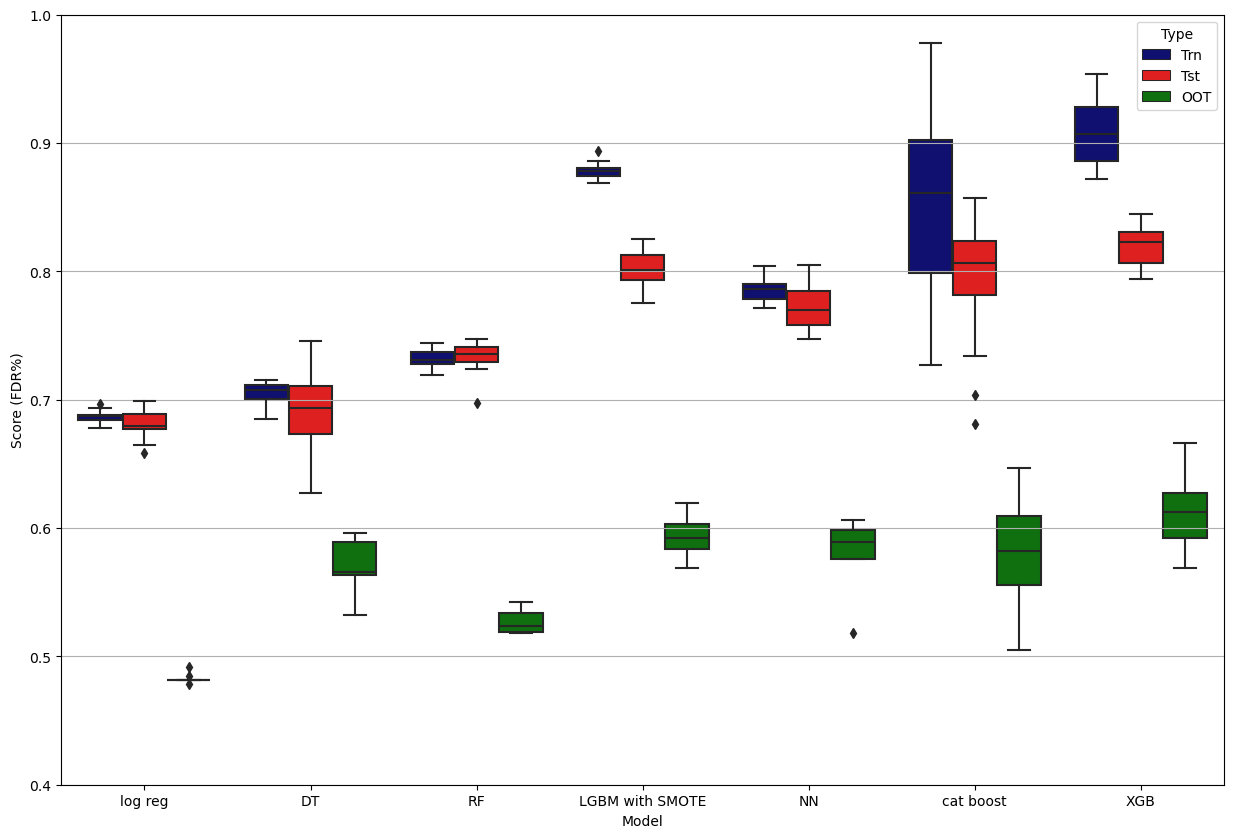

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.4,1.)
plt.ylabel('Score (FDR%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [58]:
print('duration: ', datetime.now() - start_time)

duration:  0:03:41.918033


This next cell can be used to explore overfitting

0 0.7518796992481203 0.7142857142857143 0.5084175084175084
1 0.7465362673186634 0.7246653919694073 0.5353535353535354
2 0.7395659432387313 0.7409420289855072 0.5016835016835017
loop trn tst oot 2 0.7459939699351716 0.7266310450802096 0.5151515151515151
0 0.78125 0.7509363295880149 0.5420875420875421
1 0.7736797988264879 0.7576301615798923 0.5218855218855218
2 0.7682119205298014 0.7656826568265682 0.5185185185185185
loop trn tst oot 3 0.7743805731187631 0.7580830493314918 0.5274971941638609
0 0.7970419063270336 0.7823639774859287 0.5387205387205387
1 0.7992 0.764 0.5656565656565656
2 0.7859477124183006 0.7984790874524715 0.5555555555555556
loop trn tst oot 4 0.7940632062484448 0.7816143549794666 0.5533108866442199
0 0.8263374485596707 0.7962616822429907 0.5757575757575758
1 0.8178104575163399 0.7984790874524715 0.5791245791245792
2 0.8191318327974276 0.8201581027667985 0.5757575757575758
loop trn tst oot 5 0.821093246291146 0.8049662908207535 0.5768799102132435
0 0.8412698412698413 0.80

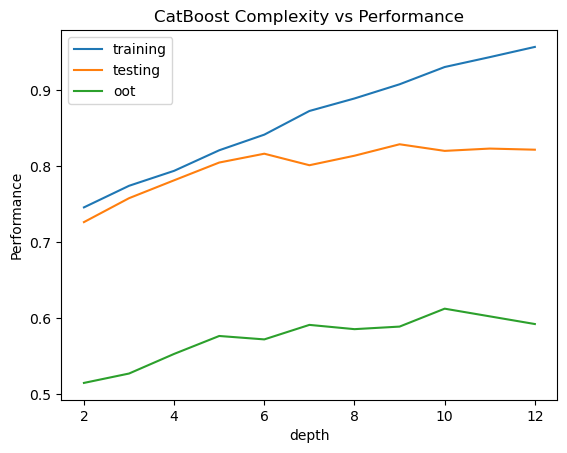

CPU times: user 17min 14s, sys: 4min 6s, total: 21min 20s
Wall time: 5min 6s


In [42]:
%%time
# This cell is used only to examine overfitting for ant particular model type.
# One can iterate through a hyperparameter's value, either increasing or decreasing it, and watching the overfitting.
nitermax2 = 3 # Lower the number of model builds for each value of hyperparameters so this cell runs faster.
training = []
testing = []
oot = []
d =[]
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])

# Here's where we set the manner of the hyperparameter's ranga and increment.
for i in range(2, 13, 1):

# Now just run the model as before.
    for niter in range(nitermax2):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
  
        io2 = int(i/2) # the min_samples_leaf can be set to half the min_samples_split for simplicity.
        model = CatBoostClassifier(learning_rate=0.01, depth=i , l2_leaf_reg=1, bagging_temperature=0, verbose=0)

        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*detect_rate))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*detect_rate))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*detect_rate))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)
    d.append(i)

#table=pd.DataFrame({'n': range(1,len(training)+1),'lr':lr,'training':training,'testing':testing,'oot':oot})
table=pd.DataFrame({'d':d,'training':training,'testing':testing,'oot':oot})
table.set_index('d',inplace=True) 
table.plot()
#plt.gca().invert_xaxis()
plt.title('CatBoost Complexity vs Performance')  # Set the title
plt.xlabel('depth')  # Set the x-axis label
plt.ylabel('Performance') 
plt.savefig('complexity_CatBoost.pdf', format='pdf')

plt.show()

In [202]:
table

training   testing       oot
lr                                 
0.001  0.731283  0.673032  0.514029
0.006  0.747293  0.747338  0.556678
0.011  0.765113  0.725630  0.572391
0.016  0.778127  0.755624  0.566779
0.021  0.797560  0.771380  0.554433
0.026  0.794232  0.771723  0.563412
0.031  0.808841  0.778376  0.595960
0.036  0.820458  0.756972  0.604938
0.041  0.821041  0.782711  0.592593
0.046  0.830777  0.764567  0.560045
0.051  0.832478  0.771474  0.573513
0.056  0.831677  0.781239  0.615039
0.061  0.836595  0.784169  0.583614
0.066  0.840762  0.806589  0.606061
0.071  0.845959  0.795732  0.618406
0.076  0.851972  0.787004  0.616162
0.081  0.860533  0.800962  0.621773
0.086  0.862051  0.800675  0.602694
0.091  0.862046  0.808265  0.615039
0.096  0.860061  0.798265  0.615039

In [200]:
table

training   testing       oot
n                               
1   0.719334  0.710955  0.545455
2   0.748925  0.755008  0.570146
3   0.770853  0.731508  0.554433
4   0.779526  0.751728  0.547699
5   0.788137  0.758218  0.561167
6   0.799493  0.780759  0.613917
7   0.812025  0.768714  0.590348
8   0.814354  0.781736  0.591470
9   0.820607  0.771172  0.599327
10  0.824896  0.782890  0.578002
11  0.833638  0.777429  0.600449
12  0.830196  0.790658  0.627385
13  0.834443  0.787163  0.602694
14  0.842758  0.781143  0.602694
15  0.842274  0.796424  0.603816
16  0.844783  0.802018  0.629630
17  0.847533  0.815017  0.593715
18  0.857544  0.805424  0.615039
19  0.863812  0.806415  0.607183
20  0.859586  0.807450  0.624018

In [60]:
best_OOT

0.5757575757575758

The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [61]:
%%time
# Note - need to set this next value to around the highest oot fdr for your model of choice.
# The model then runs a nombermof times with your fixed hyperparameters until it finds a good model.
desire = .55
print('desire =', desire)
for niter in range(50):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# Here's where you put your final model of choice.
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the oot performance where I want to break out this loop
# and that will be my final model run of choice.
    model = lgb.LGBMClassifier()

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
# choose a good break point
    if(FDR.loc[niter, 'oot'] > desire): break
    
model_counter = model_counter + 1

desire = 0.55
0 0.9776536312849162 0.8269617706237424 0.5117845117845118
1 0.9890848026868178 0.7924865831842576 0.5488215488215489
2 0.9855769230769231 0.8207171314741036 0.4882154882154882
3 0.9903225806451613 0.796078431372549 0.494949494949495
4 0.9841402337228714 0.8152173913043478 0.5185185185185185
5 0.9795417348608838 0.8125 0.468013468013468
6 0.9764227642276423 0.8153846153846154 0.5185185185185185
7 0.9868852459016394 0.7962264150943397 0.5521885521885522
CPU times: user 8.27 s, sys: 3.7 s, total: 12 s
Wall time: 3.74 s


In [62]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [63]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

Cardnum_unique_count_for_card_state_1  Card_Merchdesc_State_total_7  \
93846                               4.039168                     -0.240185   
94031                               7.900037                     -0.324574   
91007                               7.900037                     -0.324087   
94098                               6.613081                     -0.324328   
96324                               7.256559                     -0.323033   
93907                               5.326124                      0.194774   
96458                               8.543516                     -0.325933   
96249                               8.543516                     -0.270706   
90973                               7.256559                     -0.328159   
93989                               6.613081                     -0.221542   
88282                               9.830472                     -0.324023   
93991                               7.256559                     -0.327062   
94135                               7.256559                     -0.082879   
96274                               8.543516                     -0.328785   
93866                               4.682646                      0.086734   
93940                               5.969603                     -0.251689   
88288                               9.830472                     -0.325869   
95134                               7.900037                     -0.327758   
96243                               7.900037                     -0.322862   
96446                               8.543516                     -0.286475   

       Cardnum_count_1_by_30  Cardnum_max_14  Card_dow_vdratio_0by60  \
93846               0.593673       -0.122573                0.687799   
94031               1.047494       -0.114619                1.512059   
91007               2.305513       -0.185289                2.537923   
94098               0.439221       -0.114619                2.022315   
96324               1.369662       -0.188352               -0.637018   
93907               0.744249       -0.114619                1.021428   
96458               1.691996       -0.153790                2.689572   
96249               2.358835       -0.188352                2.689572   
90973               2.264040       -0.185289                2.522758   
93989               0.936899       -0.114619                1.355057   
88282               1.879867       -0.266383                1.779675   
93991               0.993776       -0.114619                1.438464   
94135               0.557716       -0.114619                2.212960   
96274               2.384689       -0.188352                2.689572   
93866               0.671471       -0.122573                0.869779   
93940               0.876574       -0.114619                1.259734   
88288               1.906733       -0.266383                1.855500   
95134               0.494519        0.384712                1.607533   
96243               2.330397       -0.188352                2.689572   
96446               1.647867       -0.153790                2.689572   

       Card_dow_vdratio_0by14  Merchnum_desc_State_total_3  \
93846                1.362130                    -0.375465   
94031                1.671754                    -0.425850   
91007                1.892914                    -0.425559   
94098                1.892914                    -0.425703   
96324               -0.753291                    -0.173246   
93907                1.513782                    -0.115773   
96458                1.892914                    -0.426661   
96249                1.892914                    -0.393688   
90973                1.892914                    -0.427990   
93989                1.627522                    -0.187428   
88282                1.598034                    -0.425521   
93991                1.651648                    -0.074768   
94135                1.892914                    

In [64]:
cost_fraud = 400
cost_fp = 20
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot

    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

bin  #recs     #g    #b          %g         %b      tot       cg  \
0      0.0    0.0    0.0   0.0    0.000000   0.000000      0.0      0.0   
1      1.0  122.0   32.0  90.0   26.229508  73.770492    122.0     32.0   
2      2.0  123.0   78.0  45.0   63.414634  36.585366    245.0    110.0   
3      3.0  122.0   93.0  29.0   76.229508  23.770492    367.0    203.0   
4      4.0  122.0  111.0  11.0   90.983607   9.016393    489.0    314.0   
..     ...    ...    ...   ...         ...        ...      ...      ...   
96    96.0  123.0  122.0   1.0   99.186992   0.813008  11743.0  11446.0   
97    97.0  122.0  122.0   0.0  100.000000   0.000000  11865.0  11568.0   
98    98.0  122.0  122.0   0.0  100.000000   0.000000  11987.0  11690.0   
99    99.0  123.0  123.0   0.0  100.000000   0.000000  12110.0  11813.0   
100  100.0  122.0  122.0   0.0  100.000000   0.000000  12232.0  11935.0   

        cb         %cg         FDR         KS        FPR  
0      0.0    0.000000    0.000000   0.000000   0.000000  
1     90.0    0.268119   30.303030  30.034911   0.355556  
2    135.0    0.921659   45.454545  44.532886   0.814815  
3    164.0    1.700880   55.218855  53.517975   1.237805  
4    175.0    2.630917   58.922559  56.291641   1.794286  
..     ...         ...         ...        ...        ...  
96   297.0   95.902807  100.000000   4.097193  38.538721  
97   297.0   96.925010  100.000000   3.074990  38.949495  
98   297.0   97.947214  100.000000   2.052786  39.360269  
99   297.0   98.977796  100.000000   1.022204  39.774411  
100  297.0  100.000000  100.000000   0.000000  40.185185  

[101 rows x 13 columns]

Max possible savings: 45,588,000.0


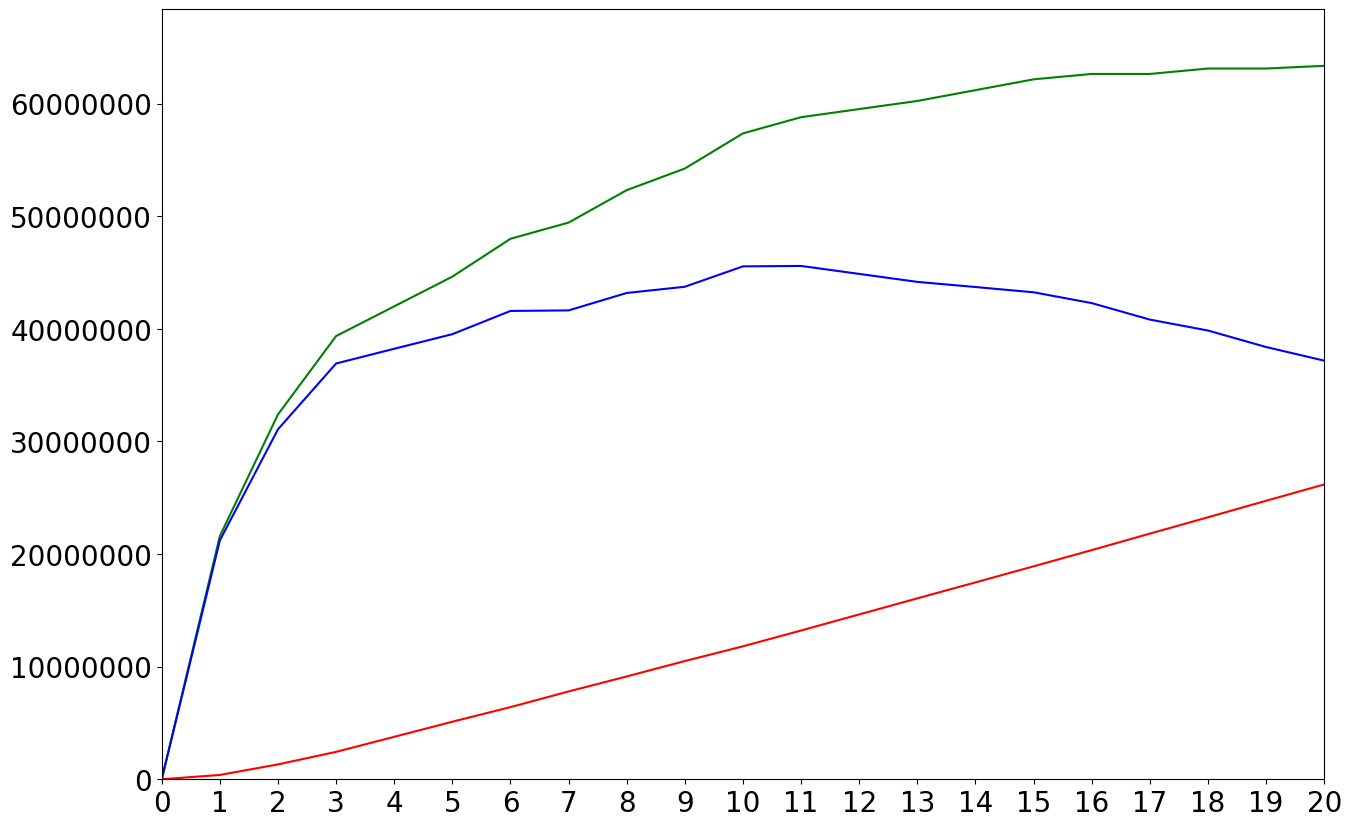

In [65]:
# xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
    Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
    Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
xlimit = 20
interval = 1
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')

In [66]:
FDR_oot.head(10)

bin  #recs     #g    #b         %g         %b     tot     cg     cb  \
0  0.0    0.0    0.0   0.0   0.000000   0.000000     0.0    0.0    0.0   
1  1.0  122.0   32.0  90.0  26.229508  73.770492   122.0   32.0   90.0   
2  2.0  123.0   78.0  45.0  63.414634  36.585366   245.0  110.0  135.0   
3  3.0  122.0   93.0  29.0  76.229508  23.770492   367.0  203.0  164.0   
4  4.0  122.0  111.0  11.0  90.983607   9.016393   489.0  314.0  175.0   
5  5.0  123.0  112.0  11.0  91.056911   8.943089   612.0  426.0  186.0   
6  6.0  122.0  108.0  14.0  88.524590  11.475410   734.0  534.0  200.0   
7  7.0  122.0  116.0   6.0  95.081967   4.918033   856.0  650.0  206.0   
8  8.0  123.0  111.0  12.0  90.243902   9.756098   979.0  761.0  218.0   
9  9.0  122.0  114.0   8.0  93.442623   6.557377  1101.0  875.0  226.0   

        %cg        FDR         KS       FPR  
0  0.000000   0.000000   0.000000  0.000000  
1  0.268119  30.303030  30.034911  0.355556  
2  0.921659  45.454545  44.532886  0.814815  
3  1.700880  55.218855  53.517975  1.237805  
4  2.630917  58.922559  56.291641  1.794286  
5  3.569334  62.626263  59.056929  2.290323  
6  4.474235  67.340067  62.865832  2.670000  
7  5.446167  69.360269  63.914103  3.155340  
8  6.376204  73.400673  67.024469  3.490826  
9  7.331378  76.094276  68.762898  3.871681

In [67]:
FDR.to_csv('FDR.csv')

In [68]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [69]:
Metrics = FDR_oot.copy()
num_good = Metrics['#g'].sum()
num_bad = Metrics['#b'].sum()
num_tot = Metrics['#recs'].sum()
print(num_good,num_bad,num_good+num_bad,num_tot)

11935.0 297.0 12232.0 12232.0


In [70]:
Metrics['TP'] = Metrics['cb']
Metrics['TN'] = num_good - Metrics['cg']
Metrics['FN'] = num_bad - Metrics['cb']
Metrics['FP'] = Metrics['cg']
Metrics['Accuracy'] = (Metrics['TP'] + Metrics['TN']) / num_tot
Metrics['Misclass'] = (Metrics['FP'] + Metrics['FN']) / num_tot
Metrics['FPRate'] = Metrics['FP'] / (Metrics['FP'] + Metrics['TN'])
Metrics['FPRatio'] = Metrics['FP'] / Metrics['TP']
Metrics['TPR'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FN'])
Metrics['TNR'] = Metrics['TN'] / (Metrics['TN'] + Metrics['FP'])
Metrics['Precision'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FP'])
Metrics['f1'] = 2 * Metrics['Precision'] * Metrics['TPR'] / (Metrics['Precision'] + Metrics['TPR'])
Metrics.to_csv('Metrics.csv')

Text(0, 0.5, 'FDR')

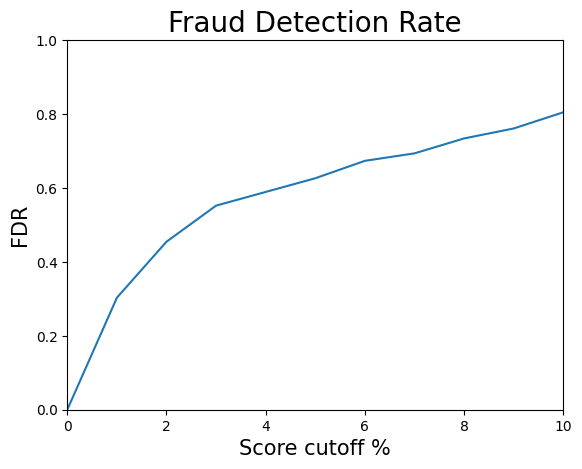

In [71]:
plt.rcParams.update({'font.size':10})
plt.plot(Metrics['bin'], Metrics['TPR'])
plt.title('Fraud Detection Rate', fontsize=20)
plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel('Score cutoff %', fontsize=15)
plt.ylabel('FDR', fontsize=15)

For a highly imbalanced problem the # goods in each bin is close to constant except for the first few bins, so the FDR curve (xaxis is bin #) and the ROC (x axis is FP, which is # goods below the cutoff) look very similar. They're only different in the first few bins where the # goods are not ~constant.

(0.0, 1.0)

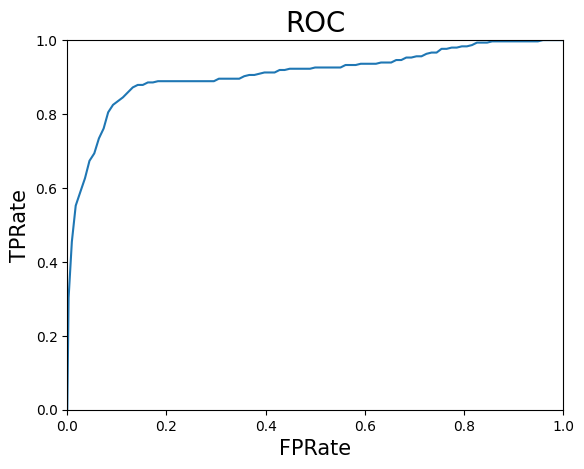

In [72]:
plt.plot(Metrics['FPRate'], Metrics['TPR'])
plt.title('ROC', fontsize=20)
plt.xlabel('FPRate',fontsize=15)
plt.ylabel('TPRate', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)

In [73]:
print("duration: ", datetime.now() - start_time)

duration:  0:04:04.063515


In [74]:
%pwd

'/Users/stevecoggeshall/Documents/Teaching/Data sets/done/transactions/give to USC 2024'

In [75]:
%%time
df = pd.read_csv('card transactions.csv')
df.dropna(how='all', axis=1, inplace=True)
df = df[df['Transtype'] == 'P']
df = df[df['Amount'] <= 3000000]
df['Date'] = pd.to_datetime(df['Date'])
df.shape

CPU times: user 259 ms, sys: 13.4 ms, total: 273 ms
Wall time: 98.2 ms


<timed exec>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


(97496, 10)

In [76]:
df['prediction'] = model.predict_proba(X)[:,1]

In [77]:
pred_scale = 1/df['prediction'].max()
df['prediction'] = df['prediction']*pred_scale

In [78]:
df.head()

Recnum     Cardnum       Date       Merchnum        Merch description  \
0       1  5142190439 2010-01-01  5509006296254   FEDEX SHP 12/23/09 AB#   
1       2  5142183973 2010-01-01    61003026333  SERVICE MERCHANDISE #81   
2       3  5142131721 2010-01-01  4503082993600        OFFICE DEPOT #191   
3       4  5142148452 2010-01-01  5509006296254   FEDEX SHP 12/28/09 AB#   
4       5  5142190439 2010-01-01  5509006296254   FEDEX SHP 12/23/09 AB#   

  Merch state  Merch zip Transtype  Amount  Fraud  prediction  
0          TN    38118.0         P    3.62      0    0.000453  
1          MA     1803.0         P   31.42      0    0.001409  
2          MD    20706.0         P  178.49      0    0.003714  
3          TN    38118.0         P    3.62      0    0.000453  
4          TN    38118.0         P    3.62      0    0.000587

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97496 entries, 0 to 97851
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             97496 non-null  int64         
 1   Cardnum            97496 non-null  int64         
 2   Date               97496 non-null  datetime64[ns]
 3   Merchnum           94276 non-null  object        
 4   Merch description  97496 non-null  object        
 5   Merch state        96468 non-null  object        
 6   Merch zip          93149 non-null  float64       
 7   Transtype          97496 non-null  object        
 8   Amount             97496 non-null  float64       
 9   Fraud              97496 non-null  int64         
 10  prediction         97496 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 8.9+ MB


In [80]:
df_sorted = df.sort_values(by=['prediction'],ascending=False)
df_sorted.head(20)

Recnum     Cardnum       Date       Merchnum  \
77122   77123  5142225942 2010-09-21  9900020006406   
63530   63531  5142249750 2010-08-13    92891948003   
63535   63536  5142249750 2010-08-13    92891948003   
63552   63553  5142249750 2010-08-13    92891948003   
63520   63521  5142249750 2010-08-13    92891948003   
45388   45389  5142134797 2010-06-15   410000971343   
68141   68142  5142223659 2010-08-26   900009096891   
20212   20213  5142214614 2010-03-20      300600391   
42222   42223  5142111125 2010-06-05   672614430336   
42236   42237  5142111125 2010-06-05  460450006HRI6   
94195   94196  5142251305 2010-12-14   930090121224   
42199   42200  5142111125 2010-06-05  8408000980533   
20301   20302  5142214614 2010-03-20  9042000846620   
20378   20379  5142214614 2010-03-20    73689635363   
20254   20255  5142214614 2010-03-20  7593860068556   
42704   42705  5142111125 2010-06-06  4620006363548   
42260   42261  5142111125 2010-06-05  7593980006836   
418       419  5142187448 2010-01-04  08-3500836951   
42375   42376  5142111125 2010-06-05  9289195900903   
20291   20292  5142214614 2010-03-20  08-3500004724   

               Merch description Merch state  Merch zip Transtype   Amount  \
77122                GSA-FSS-ADV          VA        NaN         P    18.10   
63530        ONLINE SERVICES INC          TX    75230.0         P   726.74   
63535        ONLINE SERVICES INC          TX    75230.0         P   717.17   
63552        ONLINE SERVICES INC          TX    75230.0         P   728.95   
63520        ONLINE SERVICES INC          TX    75230.0         P   809.83   
45388              SIGMA-ALDRICH          MO    63103.0         P    49.57   
68141           C.T. ENGINEERING          OH    44103.0         P   374.46   
20212      NEAL R GROSS & CO INC          DC    20005.0         P  4478.48   
42222               EWONDERS.COM          NJ     7981.0         P  4753.03   
42236             SENTINEL, INC.          AL    35801.0         P  4739.36   
94195     FEDEX SHP 09/15/10 AB#          TN    38118.0         P   176.51   
42199           HRK*TONERNOW COM          NJ     7631.0         P  4718.38   
20301      PC *PC CONNECTION FED          NH     3054.0         P  4550.43   
20378  CINTI ICE MACHINE COMPANY          OH    45206.0         P  4582.35   
20254                AMC SYSTEMS          DC    20020.0         P  5053.26   
42704    GATEWAY BUSINESS DIRECT          SD    57049.0         P  5859.05   
42260   ADVANCE COMP ELECTRONICS          VA    22304.0         P  5228.84   
418       PACIFIC AERIAL SURVEYS          CA    94621.0         P   195.60   
42375    KOETTER FIRE PROTECTION          TX    75220.0         P  4849.47   
20291  CHESAPEAKE LOCK & SAFE SE          MD    20639.0         P  4278.33   

       Fraud  prediction  
77122      1    1.000000  
63530      1    0.997661  
63535      1    0.997661  
63552      1    0.997661  
63520      1    0.997424  
45388      1    0.997332  
68141      1    0.995721  
20212      1    0.995464  
42222      1    0.994303  
42236      1    0.994303  
94195      1    0.993588  
42199      1    0.993149  
20301      1    0.992788  
20378      1    0.992788  
20254      1    0.992552  
42704      1    0.992337  
42260      1    0.992196  
418        1    0.992132  
42375      1    0.991985  
20291      1    0.991850

# Here we're going to look at specific cards or merchants to look at the dynamics of the fraud score

In [81]:
bads = df[df['Fraud']==1]
bads['Cardnum'].value_counts().head(20)

Cardnum
5142214614    60
5142271065    58
5142140316    46
5142847398    45
5142199009    45
5142219623    44
5142189341    41
5142160778    41
5142225942    41
5142212038    39
5142181728    39
5142220919    38
5142165136    37
5142202847    37
5142138135    36
5142223659    36
5142149994    35
5142226204    35
5142260253    34
5142189108    33
Name: count, dtype: int64

In [82]:
bads['Merchnum'].value_counts().head(15)

Merchnum
930090121224     151
4353000719908    116
9108234610000     48
8834000695423     46
4503738417400     45
9900020006406     43
4620009957157     41
4503082476300     39
618901687330      36
900009045549      36
253052983001      34
938909877224      32
6006333528866     30
997674930332      30
6070095870009     27
Name: count, dtype: int64

In [83]:
card = 5142140316
# card = 5142847398
# card = 5142199009
# card = 5142160778
# card = 5142189341
# card = 5142181728
# card = 5142212038
# card = 5142220919
# card = 5142214614
# card = 5142202847
# card = 5142138135
# card = 5142271065
# card = 5142152857
# card = 5142179617
# card = 5142235211
# card = 5142197711
# card = 5142182128
# card = 5142189113
# card = 5142197563 

merch = 4353000719908
# merch = 930090121224  
# merch = 48834000695423
# merch = 44503738417400
# merch = 44620009957157
# merch = 4618901687330
# merch = 4900009045549
# merch = 49108234610000
# merch = 4253052983001
# merch = 4938909877224
# merch = 44503082476300
# merch = 46006333528866
# merch = 4997674930332
# merch = 46070095870009
# merch = 49900020006406
sample = df[df['Cardnum'] == card]
# sample = df[df['Merchnum'] == str(merch)]
sample['Fraud'].sum()

46

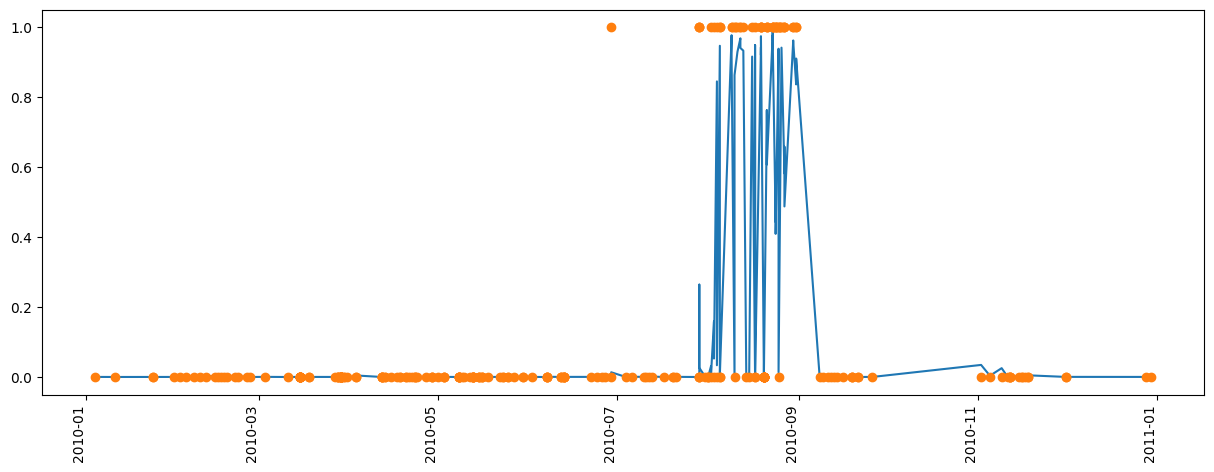

In [84]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(sample['Date'],sample['prediction'])
plt.plot_date(sample['Date'],sample['Fraud'])

In [85]:
tsample = sample[sample['Date'] > '2010-08-01']
tsample = tsample[tsample['Date'] < '2010-09-10']
tsample.reset_index(inplace=True)
tsample.reset_index(inplace=True)
tsample.rename(columns={'level_0':'counter'},inplace=True)
tsample['counter'] = tsample['counter']+1
tsample.head()

counter  index  Recnum     Cardnum       Date       Merchnum  \
0        1  59430   59431  5142140316 2010-08-02  8834000695423   
1        2  59776   59777  5142140316 2010-08-02  4620002006336   
2        3  59886   59887  5142140316 2010-08-03  8834000695423   
3        4  60227   60228  5142140316 2010-08-03   465906341338   
4        5  60345   60346  5142140316 2010-08-04  8834000695423   

        Merch description Merch state  Merch zip Transtype   Amount  Fraud  \
0  STEVES COMPUTER REPAIR          CA    92656.0         P  2629.20      1   
1            HP GSA STORE          AZ    85285.0         P   644.00      0   
2  STEVES COMPUTER REPAIR          CA    92656.0         P   560.72      1   
3      HEWLETT PACKARD CO          CA    95747.0         P   176.00      0   
4  STEVES COMPUTER REPAIR          CA    92656.0         P   487.26      1   

   prediction  
0    0.031342  
1    0.008229  
2    0.158744  
3    0.052836  
4    0.844643

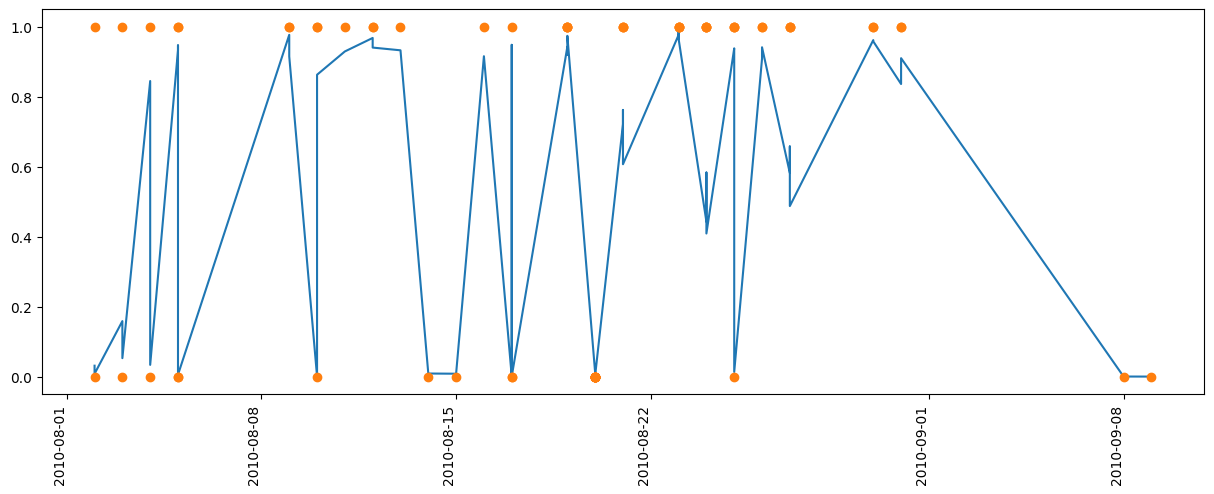

In [86]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['Date'],tsample['prediction'])
plt.plot_date(tsample['Date'],tsample['Fraud'])
plt.savefig('dynamics_time.png', format='png')

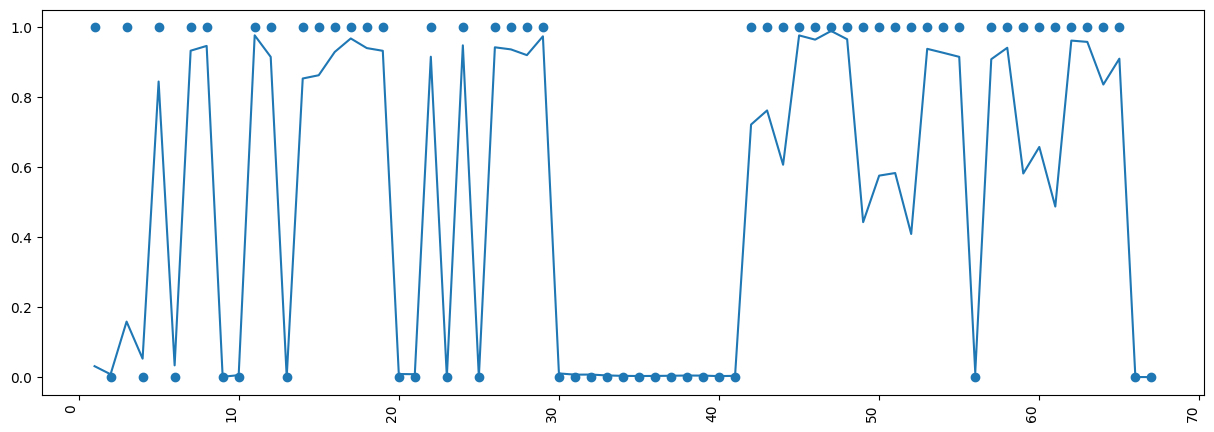

In [87]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['counter'],tsample['prediction'])
plt.scatter(tsample['counter'],tsample['Fraud'])
plt.savefig('dynamics_count.png', format='png')

In [88]:
tsample.to_csv('dynamics_transactions.csv')
tsample.head(40)

counter  index  Recnum     Cardnum       Date       Merchnum  \
0         1  59430   59431  5142140316 2010-08-02  8834000695423   
1         2  59776   59777  5142140316 2010-08-02  4620002006336   
2         3  59886   59887  5142140316 2010-08-03  8834000695423   
3         4  60227   60228  5142140316 2010-08-03   465906341338   
4         5  60345   60346  5142140316 2010-08-04  8834000695423   
5         6  60640   60641  5142140316 2010-08-04  4620002006336   
6         7  60688   60689  5142140316 2010-08-05  8834000695423   
7         8  60691   60692  5142140316 2010-08-05  8834000695423   
8         9  60758   60759  5142140316 2010-08-05   930090121224   
9        10  60792   60793  5142140316 2010-08-05   930090121224   
10       11  62107   62108  5142140316 2010-08-09  8834000695423   
11       12  62163   62164  5142140316 2010-08-09  8834000695423   
12       13  62328   62329  5142140316 2010-08-10   930090121224   
13       14  62586   62587  5142140316 2010-08-10  8834000695423   
14       15  62874   62875  5142140316 2010-08-10  8834000695423   
15       16  63214   63215  5142140316 2010-08-11  8834000695423   
16       17  63334   63335  5142140316 2010-08-12  8834000695423   
17       18  63365   63366  5142140316 2010-08-12  8834000695423   
18       19  63459   63460  5142140316 2010-08-13  8834000695423   
19       20  63696   63697  5142140316 2010-08-14   930090121224   
20       21  64194   64195  5142140316 2010-08-15   951009149220   
21       22  64651   64652  5142140316 2010-08-16  8834000695423   
22       23  64774   64775  5142140316 2010-08-17   930090121224   
23       24  64955   64956  5142140316 2010-08-17  8834000695423   
24       25  65001   65002  5142140316 2010-08-17   930090121224   
25       26  65608   65609  5142140316 2010-08-19  8834000695423   
26       27  65639   65640  5142140316 2010-08-19  8834000695423   
27       28  65645   65646  5142140316 2010-08-19  8834000695423   
28       29  65726   65727  5142140316 2010-08-19  8834000695423   
29       30  65768   65769  5142140316 2010-08-20   930090121224   
30       31  65769   65770  5142140316 2010-08-20   930090121224   
31       32  65796   65797  5142140316 2010-08-20   930090121224   
32       33  65798   65799  5142140316 2010-08-20   930090121224   
33       34  65822   65823  5142140316 2010-08-20   930090121224   
34       35  65846   65847  5142140316 2010-08-20   930090121224   
35       36  65853   65854  5142140316 2010-08-20   930090121224   
36       37  65871   65872  5142140316 2010-08-20   930090121224   
37       38  65877   65878  5142140316 2010-08-20   930090121224   
38       39  65902   65903  5142140316 2010-08-20   930090121224   
39       40  65913   65914  5142140316 2010-08-20   930090121224   

         Merch description Merch state  Merch zip Transtype   Amount  Fraud  \
0   STEVES COMPUTER REPAIR          CA    92656.0         P  2629.20      1   
1             HP GSA STORE          AZ    85285.0         P   644.00      0   
2   STEVES COMPUTER REPAIR          CA    92656.0         P   560.72      1   
3       HEWLETT PACKARD CO          CA    95747.0         P   176.00      0   
4   STEVES COMPUTER REPAIR          CA    92656.0         P   487.26      1   
5             HP GSA STORE          AZ    85285.0         P  1060.00      0   
6   STEVES COMPUTER REPAIR          CA    92656.0         P   629.09      1   
7   STEVES COMPUTER REPAIR          CA    92656.0         P  1821.05      1   
8   FEDEX SHP 07/24/10 AB#          TN    38118.0         P     5.16      0   
9   FEDEX SHP 07/21/10 AB#          TN    38118.0         P     3.57      0   
10  STEVES COMPUTER REPAIR          CA    92656.0         P   802.79      1   
11  STEVES COMPUTER REPAIR          CA    92656.0         P  1753.46      1   
12  FEDEX SHP 08/04/10 AB#          TN    38118.0         P     4.37      0   
13  STEVES COMPUTER REPAIR          CA    92656.0         P   841.22      1   
14  STEVES COMPUTER REPAIR    

In [89]:
len(tsample)

67

# Score Calibration

In [90]:
base = 600
delta = 20
odds_at_base = .1

In [91]:
df = pd.concat([X_trn_eval,X_tst_eval,X_oot_eval])
df.shape

(97496, 12)

In [92]:
df.head()

Cardnum_unique_count_for_card_state_1  Card_Merchdesc_State_total_7  \
66734                              -0.465180                     -0.318982   
9757                                1.465255                     -0.311491   
44324                               0.178299                      0.695521   
2875                               -0.465180                     -0.147352   
34604                              -0.465180                     -0.237327   

       Cardnum_count_1_by_30  Cardnum_max_14  Card_dow_vdratio_0by60  \
66734              -0.058457       -0.701629               -0.607922   
9757               -0.571216        0.260424               -0.608804   
44324              -0.257528        0.457528               -0.644663   
2875                2.927610       -0.612519                2.689572   
34604              -0.058457       -0.558259               -0.617451   

       Card_dow_vdratio_0by14  Merchnum_desc_State_total_3  \
66734               -0.699287                    -0.376708   
9757                -0.678071                    -0.418039   
44324               -0.759373                     0.183200   
2875                 1.892914                     3.226147   
34604               -0.714446                    -0.373759   

       Card_Merchdesc_total_7  Card_dow_unique_count_for_merch_zip_7  \
66734               -0.319050                              -0.503195   
9757                -0.311559                               0.066968   
44324                0.695420                              -0.503195   
2875                -0.147426                              -0.503195   
34604               -0.237398                              -0.503195   

       Cardnum_actual/toal_0  predicted  Fraud  
66734               0.659152   0.000423      0  
9757                0.659152   0.003402      0  
44324               0.659152   0.004066      0  
2875               -0.748928   0.002076      0  
34604               0.659152   0.000643      0

In [93]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

score_raw  Fraud
48200   0.000030      0
5423    0.000031      0
46674   0.000032      0
73229   0.000033      0
61983   0.000033      0

In [94]:
calib.shape

(97496, 2)

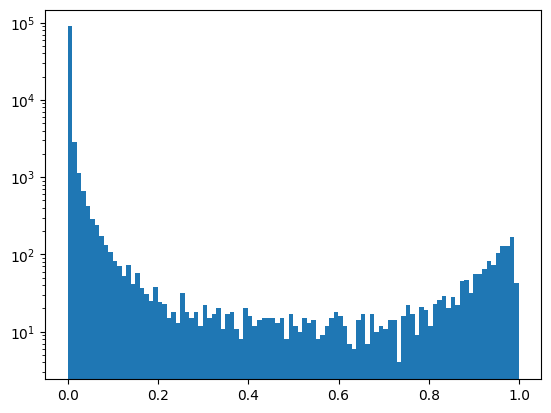

In [95]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [96]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=100
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [97]:
bad_tot = sum(calib.loc[:, 'Fraud'])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

2047 95449


In [98]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,'Fraud']))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, 'Fraud']))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log2(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

bin  #recs     #g     #b          %g         %b      tot       cg  \
1      1.0  975.0  975.0    0.0  100.000000   0.000000    975.0    975.0   
2      2.0  975.0  975.0    0.0  100.000000   0.000000   1950.0   1950.0   
3      3.0  975.0  975.0    0.0  100.000000   0.000000   2925.0   2925.0   
4      4.0  975.0  975.0    0.0  100.000000   0.000000   3900.0   3900.0   
5      5.0  975.0  975.0    0.0  100.000000   0.000000   4875.0   4875.0   
..     ...    ...    ...    ...         ...        ...      ...      ...   
96    96.0  975.0  946.0   29.0   97.025641   2.974359  93600.0  93384.0   
97    97.0  975.0  929.0   46.0   95.282051   4.717949  94575.0  94313.0   
98    98.0  975.0  801.0  174.0   82.153846  17.846154  95550.0  95114.0   
99    99.0  975.0  297.0  678.0   30.461538  69.538462  96525.0  95411.0   
100  100.0  975.0   38.0  937.0    3.897436  96.102564  97500.0  95449.0   

         cb  score_raw    prob(%)       odds   log_odds  log_odds_adj  
1       0.0   0.000054   0.000000   0.000001 -19.895043     -8.000000  
2       0.0   0.000073   0.000000   0.000001 -19.895043     -8.000000  
3       0.0   0.000088   0.000000   0.000001 -19.895043     -8.000000  
4       0.0   0.000108   0.000000   0.000001 -19.895043     -8.000000  
5       0.0   0.000135   0.000000   0.000001 -19.895043     -8.000000  
..      ...        ...        ...        ...        ...           ...  
96    212.0   0.033050   2.974359   0.030656  -5.027666     -5.027666  
97    258.0   0.054281   4.717949   0.049517  -4.335941     -4.335941  
98    432.0   0.130412  17.846154   0.217230  -2.202707     -2.202707  
99   1110.0   0.586761  69.538462   2.282832   1.190824      1.190824  
100  2047.0   0.949708  96.102564  24.657921   4.623979      4.623979  

[100 rows x 14 columns]

In [99]:
cal_bins.tail()

bin  #recs     #g     #b         %g         %b      tot       cg  \
96    96.0  975.0  946.0   29.0  97.025641   2.974359  93600.0  93384.0   
97    97.0  975.0  929.0   46.0  95.282051   4.717949  94575.0  94313.0   
98    98.0  975.0  801.0  174.0  82.153846  17.846154  95550.0  95114.0   
99    99.0  975.0  297.0  678.0  30.461538  69.538462  96525.0  95411.0   
100  100.0  975.0   38.0  937.0   3.897436  96.102564  97500.0  95449.0   

         cb  score_raw    prob(%)       odds  log_odds  log_odds_adj  
96    212.0   0.033050   2.974359   0.030656 -5.027666     -5.027666  
97    258.0   0.054281   4.717949   0.049517 -4.335941     -4.335941  
98    432.0   0.130412  17.846154   0.217230 -2.202707     -2.202707  
99   1110.0   0.586761  69.538462   2.282832  1.190824      1.190824  
100  2047.0   0.949708  96.102564  24.657921  4.623979      4.623979

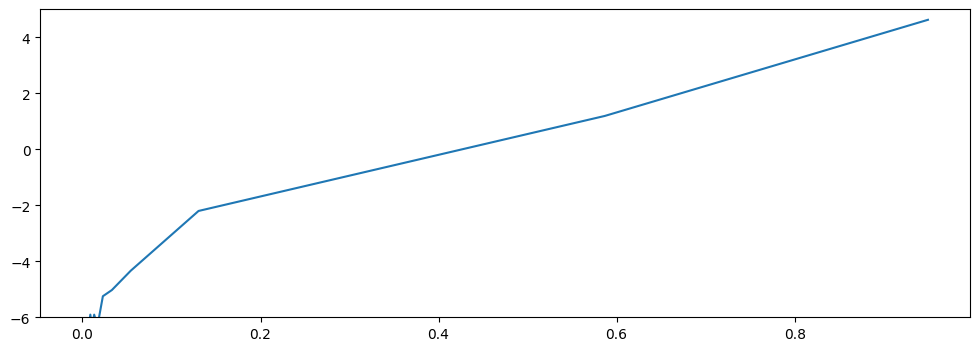

In [100]:
plt.figure(figsize=(12,4))
plt.ylim([-6,5])
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
# plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])

In [101]:
def funcg(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcf(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [102]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(funcg, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

[ 0.6902121   0.93890032 -0.00291449]


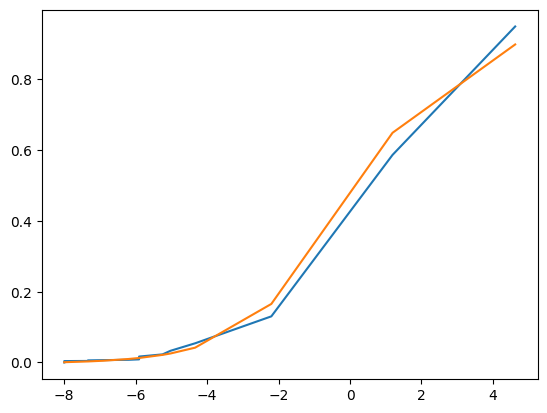

In [103]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],funcg(cal_bins['log_odds_adj'], *popt))

/opt/homebrew/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


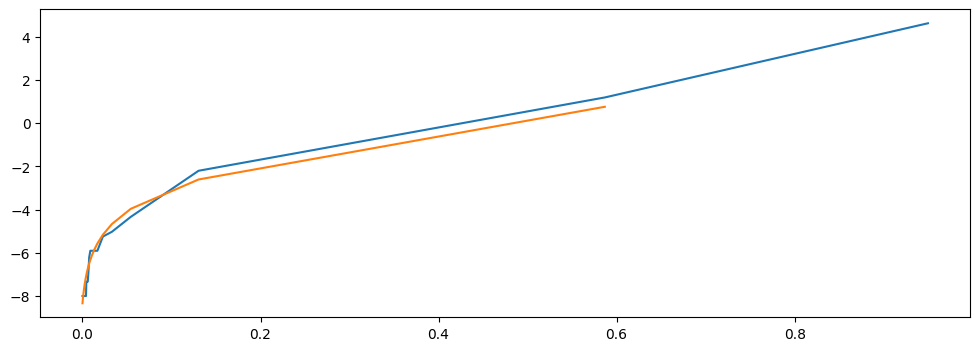

In [104]:
# look at the smooth curve fit to see if it's OK.
plt.figure(figsize=(12,4))
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcf(cal_bins['score_raw'], *popt))

In [105]:
# The fit looks pretty good
cal_bins['fit'] = funcf(cal_bins['score_raw'], *popt)
cal_bins.head(10)

bin  #recs     #g   #b          %g        %b     tot      cg   cb  \
1    1.0  975.0  975.0  0.0  100.000000  0.000000   975.0   975.0  0.0   
2    2.0  975.0  975.0  0.0  100.000000  0.000000  1950.0  1950.0  0.0   
3    3.0  975.0  975.0  0.0  100.000000  0.000000  2925.0  2925.0  0.0   
4    4.0  975.0  975.0  0.0  100.000000  0.000000  3900.0  3900.0  0.0   
5    5.0  975.0  975.0  0.0  100.000000  0.000000  4875.0  4875.0  0.0   
6    6.0  975.0  975.0  0.0  100.000000  0.000000  5850.0  5850.0  0.0   
7    7.0  975.0  975.0  0.0  100.000000  0.000000  6825.0  6825.0  0.0   
8    8.0  975.0  974.0  1.0   99.897436  0.102564  7800.0  7799.0  1.0   
9    9.0  975.0  975.0  0.0  100.000000  0.000000  8775.0  8774.0  1.0   
10  10.0  975.0  975.0  0.0  100.000000  0.000000  9750.0  9749.0  1.0   

    score_raw   prob(%)      odds   log_odds  log_odds_adj       fit  
1    0.000054  0.000000  0.000001 -19.895043          -8.0 -8.335642  
2    0.000073  0.000000  0.000001 -19.895043          -8.0 -8.326617  
3    0.000088  0.000000  0.000001 -19.895043          -8.0 -8.319199  
4    0.000108  0.000000  0.000001 -19.895043          -8.0 -8.309392  
5    0.000135  0.000000  0.000001 -19.895043          -8.0 -8.296593  
6    0.000163  0.000000  0.000001 -19.895043          -8.0 -8.283518  
7    0.000186  0.000000  0.000001 -19.895043          -8.0 -8.272757  
8    0.000206  0.102564  0.001028  -9.926336          -8.0 -8.263152  
9    0.000224  0.000000  0.000001 -19.895043          -8.0 -8.255086  
10   0.000240  0.000000  0.000001 -19.895043          -8.0 -8.247452

In [106]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

In [107]:
pd.set_option('display.max_rows', 100)
cal_bins.to_csv('cal_bins.csv')
cal_bins.tail(30)

bin  #recs     #g     #b          %g         %b      tot       cg  \
71    71.0  975.0  974.0    1.0   99.897436   0.102564  69225.0  69176.0   
72    72.0  975.0  975.0    0.0  100.000000   0.000000  70200.0  70151.0   
73    73.0  975.0  975.0    0.0  100.000000   0.000000  71175.0  71126.0   
74    74.0  975.0  973.0    2.0   99.794872   0.205128  72150.0  72099.0   
75    75.0  975.0  975.0    0.0  100.000000   0.000000  73125.0  73074.0   
76    76.0  975.0  972.0    3.0   99.692308   0.307692  74100.0  74046.0   
77    77.0  975.0  974.0    1.0   99.897436   0.102564  75075.0  75020.0   
78    78.0  975.0  974.0    1.0   99.897436   0.102564  76050.0  75994.0   
79    79.0  975.0  975.0    0.0  100.000000   0.000000  77025.0  76969.0   
80    80.0  975.0  973.0    2.0   99.794872   0.205128  78000.0  77942.0   
81    81.0  975.0  973.0    2.0   99.794872   0.205128  78975.0  78915.0   
82    82.0  975.0  975.0    0.0  100.000000   0.000000  79950.0  79890.0   
83    83.0  975.0  973.0    2.0   99.794872   0.205128  80925.0  80863.0   
84    84.0  975.0  972.0    3.0   99.692308   0.307692  81900.0  81835.0   
85    85.0  975.0  969.0    6.0   99.384615   0.615385  82875.0  82804.0   
86    86.0  975.0  970.0    5.0   99.487179   0.512821  83850.0  83774.0   
87    87.0  975.0  969.0    6.0   99.384615   0.615385  84825.0  84743.0   
88    88.0  974.0  972.0    2.0   99.794661   0.205339  85712.0  85715.0   
89    89.0  975.0  967.0    8.0   99.179487   0.820513  86775.0  86682.0   
90    90.0  975.0  962.0   13.0   98.666667   1.333333  87750.0  87644.0   
91    91.0  975.0  959.0   16.0   98.358974   1.641026  88725.0  88603.0   
92    92.0  975.0  963.0   12.0   98.769231   1.230769  89700.0  89566.0   
93    93.0  975.0  959.0   16.0   98.358974   1.641026  90675.0  90525.0   
94    94.0  975.0  963.0   12.0   98.769231   1.230769  91650.0  91488.0   
95    95.0  975.0  950.0   25.0   97.435897   2.564103  92625.0  92438.0   
96    96.0  975.0  946.0   29.0   97.025641   2.974359  93600.0  93384.0   
97    97.0  975.0  929.0   46.0   95.282051   4.717949  94575.0  94313.0   
98    98.0  975.0  801.0  174.0   82.153846  17.846154  95550.0  95114.0   
99    99.0  975.0  297.0  678.0   30.461538  69.538462  96525.0  95411.0   
100  100.0  975.0   38.0  937.0    3.897436  96.102564  97500.0  95449.0   

         cb  score_raw    prob(%)       odds   log_odds  log_odds_adj  \
71     46.0   0.001904   0.102564   0.001028  -9.926336     -8.000000   
72     46.0   0.001980   0.000000   0.000001 -19.895043     -8.000000   
73     46.0   0.002064   0.000000   0.000001 -19.895043     -8.000000   
74     48.0   0.002155   0.205128   0.002057  -8.925575     -8.000000   
75     48.0   0.002254   0.000000   0.000001 -19.895043     -8.000000   
76     51.0   0.002358   0.307692   0.003087  -8.339369     -8.000000   
77     52.0   0.002475   0.102564   0.001028  -9.926336     -8.000000   
78     53.0   0.002606   0.102564   0.001028  -9.926336     -8.000000   
79     53.0   0.002760   0.000000   0.000001 -19.895043     -8.000000   
80     55.0   0.002938   0.205128   0.002057  -8.925575     -8.000000   
81     57.0   0.003151   0.205128   0.002057  -8.925575     -8.000000   
82     57.0   0.003396   0.000000   0.000001 -19.895043     -8.000000   
83     59.0   0.003678   0.205128   0.002057  -8.925575     -8.000000   
84     62.0   0.004002   0.307692   0.003087  -8.339369     -8.000000   
85     68.0   0.004389   0.615385   0.006193  -7.335150     -7.335150   
86     73.0   0.004850   0.512821   0.005156  -7.599624     -7.335150   
87     79.0   0.005361   0.615385   0.006193  -7.335150     -7.335150   
88     81.0   0.005967   0.205339   0.002059  -8.924091     -7.335150   
89     89.0   0.006666   0.820513   0.008274  -6.917192     -6.917192   
90    102.0   0.007576   1.333333   0.013515  -6.209342     -6.209342   
91    118.0   0.008847   1.641026   0.016685  -5.905297     -5.905297   
92    130.0   0.010660   1.230769   0.012462

In [108]:
calib.head()

score_raw  Fraud
48200   0.000030      0
5423    0.000031      0
46674   0.000032      0
73229   0.000033      0
61983   0.000033      0

In [109]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcg(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

score_raw  Fraud  score_calib
48200   0.000030      0   675.769371
5423    0.000031      0   675.769375
46674   0.000032      0   675.769380
73229   0.000033      0   675.769382
61983   0.000033      0   675.769383

In [110]:
calib.tail()

score_raw  Fraud  score_calib
63301   0.995756      1   678.874447
63316   0.995993      1   678.875132
63333   0.995993      1   678.875132
63311   0.995993      1   678.875132
76825   0.998328      1   678.881867

In [111]:
calib.describe()

score_raw         Fraud   score_calib
count  97496.000000  97496.000000  97496.000000
mean       0.019498      0.020996    675.831048
std        0.112863      0.143371      0.354777
min        0.000030      0.000000    675.769371
25%        0.000454      0.000000    675.770746
50%        0.000955      0.000000    675.772370
75%        0.002307      0.000000    675.776750
max        0.998328      1.000000    678.881867

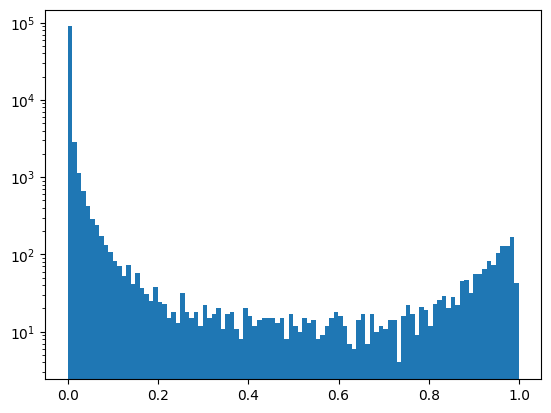

In [112]:
nbins=100
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

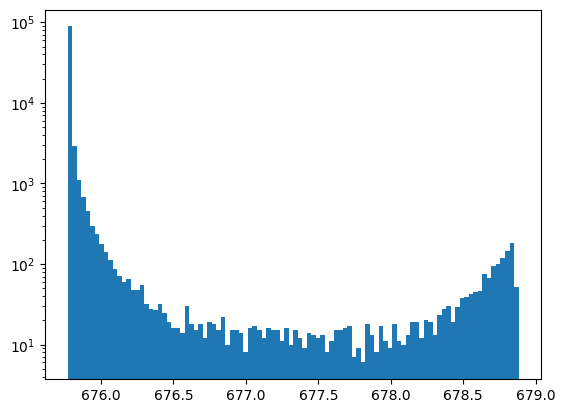

In [113]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

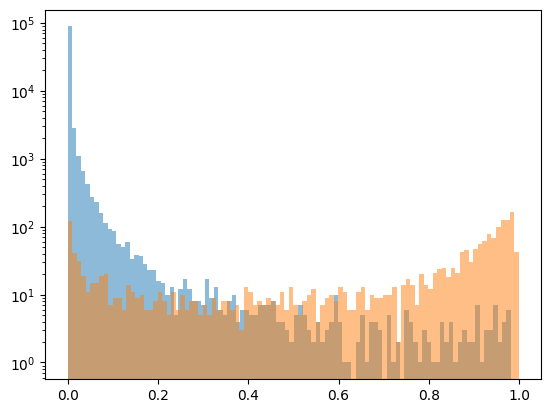

In [114]:
goods = calib[calib['Fraud']==0]
bads = calib[calib['Fraud']==1]
plt.hist(goods['score_raw'],bins = nbins, alpha = .5)
plt.hist(bads['score_raw'],bins = nbins, alpha = .5)
plt.yscale('log')

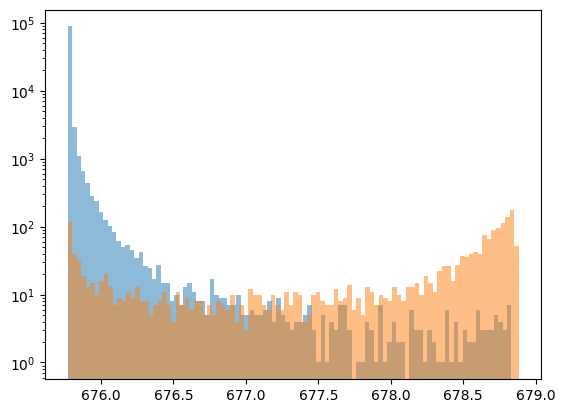

In [115]:
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [116]:
print("duration: ", datetime.now() - start_time)

duration:  0:04:06.177051


In [117]:
%pwd

'/Users/stevecoggeshall/Documents/Teaching/Data sets/done/transactions/give to USC 2024'